# Skill assessment - computation
***

**Author**: Chus Casado Rodr√≠guez<br>
**Date**: 24-03-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.



**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import sys
import operator
import glob
import numpy as np
import pandas as pd
import xarray as xr
# import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
from tqdm import tqdm_notebook

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Configuration

### 1.1 Notification criteria

#### Probability threshold

In [2]:
# probability thresholds
thresholds = np.arange(.05, .96, .05).round(2)
# thresholds = np.round(sigmoid(np.linspace(-10, 10, 50)), 5)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

#### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [88]:
persistence = [(1, 1), (2, 2), (2, 3), (3, 3), (2, 4), (3, 4), (4, 4)]
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

#### Leadtime

Notifications are only sent with a minimum leadtime (h).

In [4]:
min_leadtime = 'all'

### 1.2 Output

In [74]:
name = 'EFAS'

# path where results will be saved
path_data = '../data/'
path_forecast = f'{path_data}exceedance/forecast/'
path_reanalysis = f'{path_data}exceedance/reanalysis/'
path_out = f'{path_data}hits/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [6]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

## 2 Data

### 2.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [8]:
# load table of fixed reporing points
area_threshold = 500
stations = pd.read_parquet(f'../results/reporting_points/reporting_points_over_{area_threshold}km2.parquet')

In [9]:
# load probability of exceeding the discharge threshold in the REANALYSIS data

rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
# rean_exc = rean_exc.loc[pd.to_datetime(pred.datetime.data), stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

In [10]:
# # create a DataArray with the number of observed events per station
# n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
# stations['n_events_5'] = n_events_obs.to_pandas()
# print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))
# del rean_onsets

# # select stations with events
# mask_stn = (n_events_obs > 0).to_pandas()
# print('no. stations with events:\t{0}'.format(mask_stn.sum()))

In [11]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
del rean_exc

# expected probability of an exceedance
obs = obs.astype(int)

print(obs.dims)
print(obs.shape)

('id', 'datetime')
(2371, 3475)


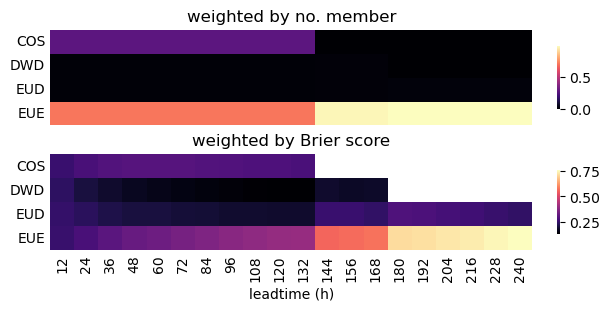

In [12]:
# by the number of membes
weights_member = xr.open_dataarray(f'{path_out}weights_member.nc')

# by the Brier score
weights_brier = xr.open_dataarray(f'{path_out}weights_brier.nc', engine='netcdf4')

# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    htm = plot_DataArray(da, vmin=0, vmax=1, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}', cbar_kws={'shrink': .66})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')

In [118]:
for stn in tqdm_notebook(stations.index):

    # check if the output file already exists
    file_out = f'{path_out}{stn:>04}.nc'
    if os.path.exists(file_out):
        continue

    # FORECAST EXCEEDANCE PROBABILITY
    
    # load forecast data to a chunked DataArray
    try:
        file = f'{path_forecast}{stn:>04}.nc'
        fore_exc = xr.open_dataset(file).exceedance
    except:
        print(f'The exceedance forecast file of station {stn} was not found:\t{file}')

    # reshape the DataArray of forecasted exceedance
    fore_exc = reshape_DataArray(fore_exc, trim=True)

    # TOTAL PROBABILITY OF EXCEEDANCE
    
    # exceedance according to current criteria
    deterministic = (fore_exc.sel(model=['EUD', 'DWD']) >= probabilities).any('model')
    probabilistic = (fore_exc.sel(model=['EUE', 'COS']) >= probabilities).any('model')
    current = deterministic & probabilistic

    # exceedance according to mean over models
    model_mean = fore_exc.mean('model', skipna=True) >= probabilities

    # exceedance according to the mean over models weighted by the number of members
    member_weighted = fore_exc.weighted(weights_member).mean('model', skipna=True) >= probabilities

    # exceedance according to the mean over models weighted by the inverse Brier score
    brier_weighted = fore_exc.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probabilities

    # merge all total probability approaches in a single DataArray
    total_exc = xr.Dataset({
                            'current': current,
                            'model_mean': model_mean,
                            'member_weighted': member_weighted,
                            'brier_weighted': brier_weighted,
                            }).to_array(dim='approach')

    del fore_exc
    
    # HITS, MISSES, FALSE ALARMS

    hits = {}
    for label, pers in persistence.items():

        # compute predicted events
        pred = compute_events(total_exc, persistence=pers, min_leadtime=min_leadtime)

        # compute hits, misses and false alarms
        if 'leadtime' in pred_events.dims:
            aux = compute_hits(obs.sel(id=stn, datetime=pred.datetime), pred, center=True, w=5)
        else:
            aux = compute_hits(obs, pred, center=True, w=5)
        aux = aux.assign_coords(persistence=label)
        hits[label] = aux.expand_dims(dim='persistence')

    hits = xr.concat(hits.values(), dim='persistence')

    print(f'Exporting file {file_out}')
    hits.to_netcdf(file_out)

    del pred, hits

  0%|          | 0/2371 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0002.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0003.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0004.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0005.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0006.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0008.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0009.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0010.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0011.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0012.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0013.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0014.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0015.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0016.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0017.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0018.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0019.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0021.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0026.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0027.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0028.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0029.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0030.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0031.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0032.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0033.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0034.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0035.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0036.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0038.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0039.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0040.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0042.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0043.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0045.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0046.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0047.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0048.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0049.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0050.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0051.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0052.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0053.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0054.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0057.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0058.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0059.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0060.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0062.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0063.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0064.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0067.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0068.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0069.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0071.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0073.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0074.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0075.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0076.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0077.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0078.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0079.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0080.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0081.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0082.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0083.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0084.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0085.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0086.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0087.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0088.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0089.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0090.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0091.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0092.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0093.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0094.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0095.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0096.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0097.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0098.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0099.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0100.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0101.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0102.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0103.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0104.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0105.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0106.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0107.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0108.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0109.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0110.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0111.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0112.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0113.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0114.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0117.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0118.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0119.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0120.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0122.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0123.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0124.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0125.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0126.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0127.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0128.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0129.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0130.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0131.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0132.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0133.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0134.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0135.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0136.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0137.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0138.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0139.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0140.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0141.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0142.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0143.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0144.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0145.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0146.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0147.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0148.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0149.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0150.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0151.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0152.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0154.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0155.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0156.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0158.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0159.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0160.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0161.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0162.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0163.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0164.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0165.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0166.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0167.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0168.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0169.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0170.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0173.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0175.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0176.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0177.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0178.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0179.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0180.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0181.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0182.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0183.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0184.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0185.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0187.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0188.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0190.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0191.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0192.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0195.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0196.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0197.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0198.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0200.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0201.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0202.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0203.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0207.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0208.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0209.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0210.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0211.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0212.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0213.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0214.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0215.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0216.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0221.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0223.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0225.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0226.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0227.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0228.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0229.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0230.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0231.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0232.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0233.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0234.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0235.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0236.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0237.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0238.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0239.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0240.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0241.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0242.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0243.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0244.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0245.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0246.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0247.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0248.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0249.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0250.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0251.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0252.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0253.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0254.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0255.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0256.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0257.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0258.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0259.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0260.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0261.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0262.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0263.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0264.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0265.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0266.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0267.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0268.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0269.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0270.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0271.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0272.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0273.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0274.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0275.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0276.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0277.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0278.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0279.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0280.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0281.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0282.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0283.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0284.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0285.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0286.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0287.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0288.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0289.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0290.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0291.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0292.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0293.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0294.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0295.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0297.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0298.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0299.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0301.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0302.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0303.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0304.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0307.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0308.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0309.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0310.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0311.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0312.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0314.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0315.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0316.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0317.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0319.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0320.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0323.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0327.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0328.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0330.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0331.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0332.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0333.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0334.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0335.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0336.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0337.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0338.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0339.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0340.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0343.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0345.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0347.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0348.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0349.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0350.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0351.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0352.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0353.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0354.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0355.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0356.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0357.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0358.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0359.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0361.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0362.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0366.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0367.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0369.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0370.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0371.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0372.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0390.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0391.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0393.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0394.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0395.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0396.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0398.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0399.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0405.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0408.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0410.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0424.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0426.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0428.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0429.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0434.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0436.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0454.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0457.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0458.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0459.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0460.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0461.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0462.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0463.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0464.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0465.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0466.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0467.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0468.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0469.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0470.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0471.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0472.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0473.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0474.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0475.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0476.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0477.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0478.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0479.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0480.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0481.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0482.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0483.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0484.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0485.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0486.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0487.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0488.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0489.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0490.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0491.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0492.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0493.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0494.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0495.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0496.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0497.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0498.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0499.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0500.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0501.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0502.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0503.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0504.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0505.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0506.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0507.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0508.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0509.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0510.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0511.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0512.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0513.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0514.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0515.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0516.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0517.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0518.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0519.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0520.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0521.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0522.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0523.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0524.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0526.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0527.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0528.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0529.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0530.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0531.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0532.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0533.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0534.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0535.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0536.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0538.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0539.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0540.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0541.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0542.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0543.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0544.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0545.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0546.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0547.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0548.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0549.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0550.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0551.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0552.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0553.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0554.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0555.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0556.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0557.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0558.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0559.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0560.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0561.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0562.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0563.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0564.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0565.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0566.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0567.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0568.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0569.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0570.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0571.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0572.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0573.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0574.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0575.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0576.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0577.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0578.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0579.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0580.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0581.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0582.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0583.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0584.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0585.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0586.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0587.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0588.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0589.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0590.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0591.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0592.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0593.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0594.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0595.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0596.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0597.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0598.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0599.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0600.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0601.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0602.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0603.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0604.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0605.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0606.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0607.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0608.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0610.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0611.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0612.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0613.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0614.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0615.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0616.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0617.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0618.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0619.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0620.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0621.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0622.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0623.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0624.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0625.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0626.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0627.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0628.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0629.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0630.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0631.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0632.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0633.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0634.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0635.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0636.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0637.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0638.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0639.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0640.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0641.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0642.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0643.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0644.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0645.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0646.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0647.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0648.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0649.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0650.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0651.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0652.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0653.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0654.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0655.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0659.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0660.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0661.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0662.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0663.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0664.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0665.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0666.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0667.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0668.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0670.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0671.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0672.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0673.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0674.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0675.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0676.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0677.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0678.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0679.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0682.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0683.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0684.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0685.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0686.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0688.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0689.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0690.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0691.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0692.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0693.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0694.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0695.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0696.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0697.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0699.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0700.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0701.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0702.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0703.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0704.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0705.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0706.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0707.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0713.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0715.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0772.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0773.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0774.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0775.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0776.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0777.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0778.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0779.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0780.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0781.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0782.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0783.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0784.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0785.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0786.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0787.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0788.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0789.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0790.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0791.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0792.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0793.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0794.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0795.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0796.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0797.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0798.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0799.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0800.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0801.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0802.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0803.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0804.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0805.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0807.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0808.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0809.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0811.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0813.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0814.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0815.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0816.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0817.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0818.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0822.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0823.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0824.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0825.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0829.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0830.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0831.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0832.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0833.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0834.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0836.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0837.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0838.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0839.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0840.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0841.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0842.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0843.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0844.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0845.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0846.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0850.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0851.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0852.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0853.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0854.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0856.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0857.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0858.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0859.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0860.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0863.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0864.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0866.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0867.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0868.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0869.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0870.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0876.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0879.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0882.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0883.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0884.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0886.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0888.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0891.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0892.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0893.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0894.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0895.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0900.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0903.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0904.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0905.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0906.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0912.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0914.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0919.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0920.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0921.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0922.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0924.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0928.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0930.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0931.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0932.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0933.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0934.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0936.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0940.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0941.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0945.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0952.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0953.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0954.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0956.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0960.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0968.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0969.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0972.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0973.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0974.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0975.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0976.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0977.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0978.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0979.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0980.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0982.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0986.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0988.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0990.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0994.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0997.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/0998.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1002.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1003.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1006.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1007.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1008.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1009.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1010.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1011.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1012.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1013.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1014.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1015.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1016.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1017.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1018.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1019.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1020.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1021.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1022.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1026.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1030.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1031.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1033.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1036.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1037.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1040.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1041.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1048.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1050.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1056.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1060.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1061.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1062.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1068.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1075.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1076.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1077.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1082.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1083.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1086.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1088.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1091.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1092.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1099.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1101.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1103.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1107.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1110.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1114.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1115.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1118.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1119.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1121.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1125.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1131.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1132.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1137.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1140.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1141.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1145.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1148.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1152.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1154.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1155.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1157.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1158.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1159.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1161.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1162.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1163.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1164.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1165.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1168.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1169.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1172.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1173.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1174.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1175.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1177.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1178.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1179.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1180.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1181.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1182.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1183.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1185.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1187.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1188.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1190.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1191.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1192.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1194.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1195.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1196.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1197.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1198.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1200.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1201.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1203.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1205.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1206.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1207.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1209.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1210.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1220.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1223.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1228.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1231.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1235.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1238.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1240.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1241.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1247.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1250.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1253.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1260.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1262.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1263.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1264.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1266.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1269.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1272.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1274.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1279.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1281.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1284.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1285.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1289.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1290.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1291.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1300.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1306.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1308.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1311.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1316.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1321.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1322.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1324.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1325.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1327.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1328.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1330.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1331.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1332.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1334.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1335.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1337.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1339.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1340.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1341.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1342.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1343.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1344.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1345.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1346.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1348.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1349.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1350.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1351.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1353.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1354.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1356.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1357.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1358.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1359.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1360.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1361.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1362.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1363.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1364.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1365.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1366.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1367.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1368.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1369.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1370.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1371.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1372.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1373.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1374.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1375.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1376.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1377.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1378.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1399.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1400.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1401.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1402.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1403.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1404.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1405.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1406.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1407.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1408.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1409.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1410.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1411.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1412.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1413.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1414.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1415.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1416.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1417.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1418.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1419.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1420.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1421.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1423.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1428.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1430.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1433.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1434.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1435.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1436.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1437.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1439.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1441.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1443.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1447.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1448.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1450.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1451.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1453.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1454.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1458.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1459.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1464.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1465.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1467.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1469.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1470.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1473.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1479.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1480.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1481.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1482.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1483.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1484.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1485.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1486.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1487.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1488.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1489.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1490.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1492.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1493.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1494.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1495.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1496.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1499.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1503.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1506.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1509.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1510.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1514.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1519.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1526.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1527.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1529.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1531.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1534.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1535.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1536.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1537.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1542.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1543.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1544.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1545.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1546.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1550.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1551.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1552.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1553.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1554.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1557.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1558.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1559.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1560.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1564.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1565.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1568.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1569.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1572.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1573.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1575.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1580.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1589.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1592.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1595.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1598.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1604.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1605.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1606.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1607.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1608.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1609.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1610.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1611.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1612.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1613.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1614.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1615.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1616.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1617.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1618.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1619.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1620.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1622.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1623.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1624.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1625.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1626.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1627.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1628.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1629.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1630.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1631.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1632.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1633.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1634.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1635.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1636.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1637.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1638.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1639.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1640.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1642.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1643.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1645.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1646.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1647.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1652.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1653.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1664.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1672.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1675.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1680.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1681.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1683.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1685.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1688.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1690.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1696.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1697.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1698.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1700.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1702.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1703.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1704.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1705.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1706.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1707.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1708.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1714.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1715.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1716.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1717.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1718.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1719.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1720.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1722.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1723.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1724.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1725.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1726.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1727.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1729.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1730.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1731.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1732.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1733.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1734.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1736.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1737.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1738.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1739.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1740.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1741.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1742.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1743.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1744.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1746.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1748.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1795.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1797.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1798.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1799.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1800.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1801.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1802.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1804.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1805.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1806.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1807.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1808.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1809.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1810.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1811.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1812.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1814.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1815.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1816.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1817.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1818.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1819.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1820.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1821.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1822.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1823.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1824.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1825.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1826.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1828.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1829.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1830.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1831.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1832.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1833.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1834.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1835.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1836.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1837.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1839.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1840.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1842.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1843.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1844.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1845.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1847.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1848.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1849.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1850.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1851.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1852.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1853.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1854.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1855.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1856.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1857.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1858.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1859.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1860.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1861.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1866.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1867.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1869.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1876.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1877.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1878.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1879.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1880.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1881.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1882.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1883.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1888.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1889.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1890.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1891.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1892.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1893.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1894.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1895.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1896.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1897.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1898.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1899.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1900.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1901.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1902.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1903.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1904.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1905.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1906.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1907.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1908.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1910.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1911.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1912.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1913.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1915.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1916.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1918.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1919.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1920.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1921.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1922.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1923.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1924.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1925.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1926.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1927.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1928.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1929.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1930.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1931.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1932.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1933.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1934.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1935.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1937.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1938.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1939.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1940.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1941.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1942.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1943.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1944.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1945.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1946.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1947.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1948.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1949.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1950.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1951.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1952.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1953.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1954.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1955.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1956.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1957.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1958.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1959.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1960.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1961.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1962.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1963.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1964.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1965.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1966.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1967.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1968.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1969.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1970.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1971.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1972.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1973.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1974.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1975.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1976.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1977.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1978.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1979.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1980.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1981.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1982.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1983.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1984.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1985.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1986.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1987.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1988.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1989.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1990.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1991.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1992.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1993.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1994.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1995.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1996.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1997.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1998.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/1999.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2000.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2001.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2002.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2003.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2004.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2005.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2006.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2007.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2008.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2009.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2010.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2011.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2012.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2013.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2014.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2015.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2016.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2018.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2019.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2020.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2021.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2022.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2023.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2024.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2025.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2026.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2027.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2028.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2029.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2030.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2031.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2032.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2033.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2034.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2035.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2036.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2038.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2039.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2040.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2042.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2046.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2047.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2051.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2053.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2058.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2059.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2062.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2064.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2065.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2072.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2083.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2088.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2089.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2090.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2092.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2093.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2094.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2095.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2096.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2097.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2098.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2100.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2116.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2118.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2119.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2120.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2122.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2125.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2126.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2127.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2128.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2129.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2130.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2131.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2137.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2140.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2142.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2145.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2146.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2147.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2148.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2149.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2150.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2151.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2154.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2155.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2156.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2158.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2159.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2160.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2161.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2162.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2163.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2164.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2165.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2166.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2167.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2168.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2169.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2170.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2171.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2173.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2174.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2175.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2176.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2177.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2178.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2179.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2180.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2181.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2182.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2183.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2184.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2185.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2187.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2188.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2190.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2191.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2193.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2194.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2195.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2197.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2200.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2201.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2203.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2205.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2206.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2207.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2208.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2209.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2210.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2211.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2212.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2213.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2214.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2215.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2221.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2222.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2223.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2224.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2225.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2230.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2231.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2232.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2234.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2236.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2237.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2238.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2239.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2240.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2241.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2242.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2243.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2244.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2245.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2248.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2249.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2252.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2254.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2255.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2257.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2258.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2259.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2260.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2266.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2267.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2268.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2269.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2271.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2272.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2273.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2274.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2275.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2280.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2284.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2292.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2295.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2301.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2303.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2304.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2306.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2308.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2310.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2317.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2318.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2320.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2322.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2326.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2333.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2337.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2341.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2346.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2352.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2354.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2356.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2357.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2358.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2359.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2362.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2363.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2364.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2365.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2373.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2376.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2378.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2379.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2388.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2390.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2391.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2403.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2405.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2406.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2418.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2420.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2421.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2425.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2428.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2431.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2432.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2433.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2447.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2450.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2455.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2460.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2471.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2480.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2481.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2482.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2483.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2484.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2487.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2488.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2489.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2490.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2491.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2492.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2493.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2494.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2495.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2496.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2497.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2498.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2499.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2500.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2501.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2502.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2503.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2504.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2505.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2516.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2517.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2520.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2526.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2527.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2528.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2529.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2532.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2533.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2534.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2535.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2536.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2538.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2542.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2543.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2544.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2546.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2548.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2551.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2556.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2560.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2562.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2564.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2565.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2566.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2568.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2569.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2587.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2588.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2589.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2590.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2591.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2592.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2594.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2596.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2597.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2598.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2599.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2600.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2603.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2605.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2606.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2607.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2609.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2610.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2611.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2612.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2613.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2615.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2616.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2619.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2620.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2622.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2623.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2624.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2625.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2627.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2629.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2630.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2632.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2634.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2635.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2637.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2662.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2664.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2666.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2667.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2668.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2669.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2670.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2674.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2679.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2681.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2682.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2685.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2686.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2687.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2688.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2691.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2692.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2693.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2697.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2699.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2700.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2701.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2702.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2703.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2705.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2707.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2709.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2710.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2711.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2712.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2713.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2716.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2721.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2722.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2723.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2724.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2725.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2726.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2727.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2728.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2729.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2731.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2732.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2734.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2735.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2736.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2737.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2738.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2739.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2740.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2741.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2743.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2744.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2746.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2747.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2748.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2749.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2750.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2751.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2752.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2753.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2754.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2755.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2756.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2757.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2758.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2762.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2763.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2764.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2765.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2766.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2768.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2769.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2770.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2771.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2772.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2773.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2774.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2775.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2776.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2777.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2778.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2779.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2780.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2781.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2782.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2783.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2784.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2785.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2786.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2787.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2788.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2789.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2790.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2791.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2792.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2794.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2795.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2797.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2798.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2799.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2800.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2801.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2803.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2804.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2805.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2806.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2809.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2810.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2812.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2813.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2818.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2821.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2822.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2823.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2824.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2825.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2826.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2827.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2828.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2829.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2830.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2832.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2834.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2835.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2836.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2838.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2839.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2840.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2841.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2842.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2843.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2844.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2845.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2846.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2847.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2848.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2849.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2851.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2853.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2854.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2855.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2857.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2858.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2859.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2860.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2861.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2862.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2863.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2864.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2865.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2866.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2867.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2868.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2869.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2870.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2871.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2872.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2873.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2874.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2875.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2876.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2877.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2878.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2879.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2880.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2881.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2882.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2883.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2884.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2885.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2886.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2887.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2888.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2889.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2890.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2891.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2892.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2893.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2894.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2895.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2896.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2897.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2898.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2899.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2900.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2901.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2902.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2903.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2904.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2905.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2907.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2908.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2910.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2911.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2912.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2913.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2914.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2915.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2916.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2918.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2919.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2920.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2921.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2922.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2923.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2924.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2925.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2926.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2927.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2928.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2929.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2930.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2931.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2932.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2933.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2934.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2935.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2936.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2937.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2938.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2939.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2940.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2941.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2942.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2943.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2944.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2945.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2946.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2947.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2948.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2949.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2950.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2951.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2952.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2953.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2954.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2955.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2956.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2957.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2958.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2959.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2960.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2961.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2962.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2963.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2964.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2965.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2966.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2967.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2968.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2969.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2970.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2972.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2973.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2975.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2976.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2977.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2978.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2980.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2983.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2985.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2986.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2988.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2989.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2991.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2992.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2993.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2994.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2995.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2996.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2997.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2998.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/2999.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3000.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3001.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3002.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3003.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3004.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3005.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3006.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3007.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3008.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3010.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3011.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3012.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3013.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3014.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3017.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3018.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3019.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3020.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3021.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3022.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3025.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3030.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3031.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3032.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3034.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3035.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3036.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3037.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3041.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3042.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3043.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3046.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3047.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3078.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3079.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3081.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3083.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3086.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3087.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3093.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3094.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3095.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3096.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3097.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3098.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3099.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3100.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3101.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3102.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3103.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3104.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3105.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3106.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3107.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3108.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3109.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3110.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3111.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3112.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3113.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3114.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3115.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3116.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3117.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3118.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3120.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3121.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3122.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3123.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3124.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3125.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3127.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3129.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3130.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3131.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3133.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3135.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3136.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3137.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3138.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3140.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3141.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3142.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3143.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3144.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3145.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3146.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3147.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3148.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3149.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3150.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3151.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3152.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3154.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3155.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3156.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3157.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3158.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3159.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3160.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3161.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3162.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3163.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3164.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3165.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3166.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3167.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3168.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3169.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3170.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3171.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3172.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3173.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3174.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3175.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3176.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3177.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3178.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3179.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3180.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3181.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3182.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3183.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3184.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3185.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3187.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3188.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3190.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3191.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3192.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3193.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3194.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3195.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3196.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3197.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3198.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3200.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3201.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3202.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3203.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3204.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3205.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3206.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3207.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3208.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3209.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3210.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3211.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3212.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3213.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3214.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3215.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3216.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3217.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3218.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3219.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3220.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3221.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3223.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3224.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3225.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3226.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3227.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3228.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3229.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3230.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3232.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3233.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3235.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3236.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3237.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3238.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3239.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3240.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3241.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3242.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3243.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3244.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3245.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3246.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3247.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3248.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3249.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3250.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3251.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3252.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3253.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3254.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3255.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3256.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3257.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3258.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3259.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3267.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3271.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3272.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3278.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3279.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3280.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3281.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3282.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3283.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3284.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3286.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3287.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3307.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3308.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3309.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3310.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3313.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3314.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3317.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3320.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3321.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3322.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3324.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3325.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3328.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3333.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3337.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3338.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3340.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3343.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3344.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3345.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3346.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3347.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3348.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3349.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3350.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3351.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3352.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3353.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3354.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/3355.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4001.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4003.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4004.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4006.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4007.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4008.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4009.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4011.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4013.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4014.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4015.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4016.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4017.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4020.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4110.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4111.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4113.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4114.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4115.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4116.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4119.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4125.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4126.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4128.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4131.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4133.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4140.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4141.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4142.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4143.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4148.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4157.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4160.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4172.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4174.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4182.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4192.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4205.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4211.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4212.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4213.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4216.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4232.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4235.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4236.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4245.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4247.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4248.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4257.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4258.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4272.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4273.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4282.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4288.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4289.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4291.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4292.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4293.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4294.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4298.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4300.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4306.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4307.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4308.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4309.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4310.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4311.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4312.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4314.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4316.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4318.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4319.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4321.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4322.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4323.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4324.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4325.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4327.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4328.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4329.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4334.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4336.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4338.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4339.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4343.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4344.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4346.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4347.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4350.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4351.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4352.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4353.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4358.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4359.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4367.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4385.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4388.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4391.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4409.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4415.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4416.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4417.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4418.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4419.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4421.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4422.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4430.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4433.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4436.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4437.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4439.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4441.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4443.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4446.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4447.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4449.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4450.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4451.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4452.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4453.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4455.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4456.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4457.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4458.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4459.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4460.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4463.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4464.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4466.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4468.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4469.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4471.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4472.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4473.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4483.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4484.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4485.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4486.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4488.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4489.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4490.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4492.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4497.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4498.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4500.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4504.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4513.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4514.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4515.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4520.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4521.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4522.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4523.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4524.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4525.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4526.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4527.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4528.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4529.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4530.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4531.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4533.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4534.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4536.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4538.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4541.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4547.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4548.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4551.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4553.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4554.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4555.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4558.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4559.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4563.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4564.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4565.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4566.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4574.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4576.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4578.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4581.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4583.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4584.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4585.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4586.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4593.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4595.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4601.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4604.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4611.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4612.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4614.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4622.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4625.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4627.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/4628.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5066.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5067.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5069.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5071.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5073.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5074.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5076.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5078.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5137.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5141.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5144.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5145.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5147.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5151.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5152.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5153.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5154.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5155.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5156.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5160.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5161.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5162.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5163.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5164.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5165.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5167.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5169.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5174.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5175.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5179.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5183.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5186.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5188.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5189.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5196.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5199.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5202.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5203.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5204.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5205.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5206.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5208.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5209.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5211.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5212.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5213.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5214.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5215.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5218.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5220.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5221.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5223.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5224.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5225.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5226.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5228.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5230.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5231.nc


  0%|          | 0/7 [00:00<?, ?it/s]

Exporting file ../data/hits/5232.nc
